In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import math
import shutil

In [2]:
ROOT_DIR="./Brain Tumor Data Set"
number_of_images={}

for dir in os.listdir(ROOT_DIR):
    number_of_images[dir]=len(os.listdir(os.path.join(ROOT_DIR,dir)))

In [3]:
number_of_images.items()

dict_items([('Brain Tumor', 17), ('Healthy', 16)])

In [4]:
def dataFolder(p,split):
    
    if not os.path.exists("./"+p):
        os.mkdir("./"+p)
    
        for dir in os.listdir(ROOT_DIR):
            os.makedirs("./"+p+"/"+dir)
        
            for img in np.random.choice(a=os.listdir(os.path.join(ROOT_DIR,dir)),size=(math.floor(split*number_of_images[dir])-5),replace=False):
        
                O=os.path.join(ROOT_DIR,dir,img)
                D=os.path.join("./"+p,dir)
                shutil.copy(O,D)
                os.remove(O)
    else:
        print("folder exists")
    

In [5]:
dataFolder("train",0.7)

folder exists


In [6]:
dataFolder("val",0.15)

folder exists


In [7]:
dataFolder("test",0.15)

folder exists


In [8]:
from keras.layers import Conv2D,MaxPool2D,Dropout,Flatten,Dense,BatchNormalization,GlobalAvgPool2D
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
import keras

In [9]:
model=Sequential()
model.add(Conv2D(filters=16,kernel_size=(3,3),activation='relu',input_shape=(224,224,3)))

model.add(Conv2D(filters=36,kernel_size=(3,3),activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=128,kernel_size=(3,3),activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Dropout(rate=(0.25)))

model.add(Flatten())

model.add(Dense(units=64,activation='relu'))

model.add(Dropout(rate=0.25))

model.add(Dense(units=1,activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 220, 220, 36)      5220      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 36)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 108, 108, 64)      20800     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 52, 52, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 128)       0

In [10]:
model.compile(optimizer='adam',loss=keras.losses.binary_crossentropy,metrics=['accuracy'])

In [11]:
def preprocessingImages1(path):
    
    '''input:paht
    output:preprocessed images
    '''
    
    image_data=ImageDataGenerator(zoom_range=0.2,shear_range=0.2,rescale=1/255,horizontal_flip=True)
    
    image=image_data.flow_from_directory(directory=path,target_size=(224,224),batch_size=32,class_mode='binary')
    
    return image

In [12]:
path="./train"
train_data=preprocessingImages1(path)
print(train_data)

Found 3209 images belonging to 2 classes.


In [13]:
def preprocessingImages2(path):
    
    '''input:paht
    output:preprocessed images
    '''
    
    image_data=ImageDataGenerator(rescale=1/255)
    
    image=image_data.flow_from_directory(directory=path,target_size=(224,224),batch_size=32,class_mode='binary')
    
    return image

In [14]:
path="./test"
test_data=preprocessingImages2(path)

Found 679 images belonging to 2 classes.


In [15]:
path="./val"
val_data=preprocessingImages2(path)

Found 679 images belonging to 2 classes.


In [16]:
# early stopping and model checkpoint

from keras.callbacks import ModelCheckpoint,EarlyStopping

es=EarlyStopping(monitor="val_accuracy",min_delta=0.01,patience=6,verbose=1,mode='auto')

mc=ModelCheckpoint(monitor="val_accuracy",filepath="./bestmodel.h5",verbose=1,save_best_only=True,mode='auto')

cd=[es,mc]


# Model Training

In [17]:
hs=model.fit_generator(generator=train_data,
                    steps_per_epoch=8,
                    epochs=30,
                    verbose=1,
                    validation_data=val_data,
                    validation_steps=16,
                    callbacks=cd)

C:\Users\DELL\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
8/8 [==============================] - 43s 6s/step - loss: 0.7973 - accuracy: 0.5027 - val_loss: 0.6734 - val_accuracy: 0.5293

Epoch 00001: val_accuracy improved from -inf to 0.52930, saving model to .\bestmodel.h5
Epoch 2/30
8/8 [==============================] - 38s 5s/step - loss: 0.6775 - accuracy: 0.5511 - val_loss: 0.6060 - val_accuracy: 0.6426

Epoch 00002: val_accuracy improved from 0.52930 to 0.64258, saving model to .\bestmodel.h5
Epoch 3/30
8/8 [==============================] - 37s 5s/step - loss: 0.6710 - accuracy: 0.6312 - val_loss: 0.5883 - val_accuracy: 0.6875

Epoch 00003: val_accuracy improved from 0.64258 to 0.68750, saving model to .\bestmodel.h5
Epoch 4/30
8/8 [==============================] - 36s 5s/step - loss: 0.6380 - accuracy: 0.6015 - val_loss: 0.6255 - val_accuracy: 0.7109

Epoch 00004: val_accuracy improved from 0.68750 to 0.71094, saving model to .\bestmodel.h5
Epoch 5/30
8/8 [==============================] - 37s 5s/step - loss: 0.5855 - accu

In [18]:
h=hs.history
h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Text(0.5, 1.0, 'acc vs val-acc')

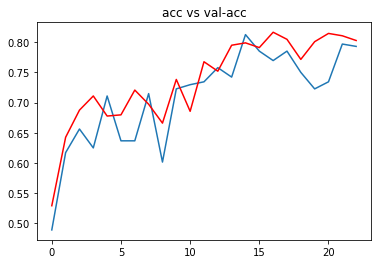

In [19]:
import matplotlib.pyplot as plt

plt.plot(h['accuracy'])
plt.plot(h['val_accuracy'],c="red")

plt.title("acc vs val-acc")

Text(0.5, 1.0, 'loss vs val-loss')

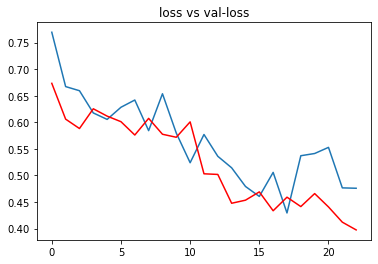

In [20]:
plt.plot(h['loss'])
plt.plot(h['val_loss'],c="red")

plt.title("loss vs val-loss")

In [21]:
from keras.models import load_model

model=load_model("./bestmodel.h5")

# Model Accuracy

In [22]:
acc=model.evaluate(test_data)[1]

print(f"accuracy of the model is {acc*100}%")

22/22 [==============================] - 16s 735ms/step - loss: 0.4423 - accuracy: 0.8159
accuracy of the model is 81.5905749797821%


In [23]:
print(os.getcwd())

C:\Users\DELL\3D Objects\BrainTumorDetection


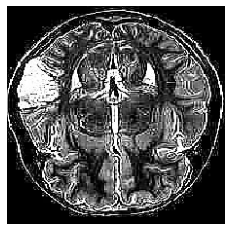

Brain Tumor Detected


In [27]:
from keras.preprocessing.image import load_img,img_to_array
path= "./Brain Tumor Data Set/Brain Tumor/Cancer (1311).jpg"

img=load_img(path,target_size=(224,224))
input_arr=img_to_array(img)/255
plt.imshow(input_arr)
plt.axis("off")
plt.show()
input_arr=np.expand_dims(input_arr,axis=0)

pred=model.predict_classes(input_arr)

if(pred==0):
    print("Brain Tumor Detected")

else:
    print("No Brain Tumor")

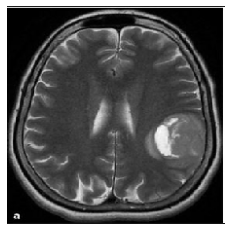

Brain Tumor Detected


In [26]:
from keras.preprocessing.image import load_img,img_to_array

path= "./Brain Tumor Data Set/Brain Tumor/Cancer (2282).jpg"

img=load_img(path,target_size=(224,224))
input_arr=img_to_array(img)/255
plt.imshow(input_arr)
plt.axis("off")
plt.show()
input_arr=np.expand_dims(input_arr,axis=0)

pred=model.predict_classes(input_arr)

if(pred==0):
    print("Brain Tumor Detected")

else:
    print("No Brain Tumor")


# Transfer Learning

In [34]:
from keras.layers import Flatten,Dense
from keras.models import Model,load_model

from keras.applications.mobilenet import MobileNet,preprocess_input



In [35]:
def preprocessingImages3(path):
        
    image_data=ImageDataGenerator(preprocessing_function=preprocess_input)
    
    image=image_data.flow_from_directory(directory=path,target_size=(224,224),batch_size=32,class_mode='binary')
    
    return image

In [36]:
path="./train"
train_data=preprocessingImages3(path)

Found 3209 images belonging to 2 classes.


In [37]:
path="./test"
test_data=preprocessingImages3(path)

path="./val"
val_data=preprocessingImages3(path)

Found 679 images belonging to 2 classes.
Found 679 images belonging to 2 classes.


In [38]:
base_model=MobileNet(input_shape=(224,224,3),include_top=False)

In [39]:
for layers in base_model.layers:
    layers.trainable=False

In [40]:
base_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32

In [41]:
X=Flatten()(base_model.output)
X=Dense(units=1,activation='sigmoid')(X)

model=Model(base_model.input,X)
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0     

In [42]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])


In [43]:
from keras.callbacks import ModelCheckpoint,EarlyStopping

mc=ModelCheckpoint(filepath="bestmodeltl.h5",monitor='val_accuracy',verbose=1,save_best_only=True)
es=EarlyStopping(monitor='val_accuracy',patience=3,verbose=1,min_delta=0.01)

cb=[mc,es]

In [44]:
hist=model.fit(train_data,steps_per_epoch=8,epochs=30,validation_data=val_data,validation_steps=16,callbacks=cb)

Epoch 1/30
8/8 [==============================] - 22s 3s/step - loss: 3.6374 - accuracy: 0.6187 - val_loss: 0.8564 - val_accuracy: 0.8379

Epoch 00001: val_accuracy improved from -inf to 0.83789, saving model to bestmodeltl.h5
Epoch 2/30
8/8 [==============================] - 19s 3s/step - loss: 1.0849 - accuracy: 0.8528 - val_loss: 0.6559 - val_accuracy: 0.8730

Epoch 00002: val_accuracy improved from 0.83789 to 0.87305, saving model to bestmodeltl.h5
Epoch 3/30
8/8 [==============================] - 21s 3s/step - loss: 0.5014 - accuracy: 0.9046 - val_loss: 0.4545 - val_accuracy: 0.8887

Epoch 00003: val_accuracy improved from 0.87305 to 0.88867, saving model to bestmodeltl.h5
Epoch 4/30
8/8 [==============================] - 21s 3s/step - loss: 0.3351 - accuracy: 0.9082 - val_loss: 0.3217 - val_accuracy: 0.9180

Epoch 00004: val_accuracy improved from 0.88867 to 0.91797, saving model to bestmodeltl.h5
Epoch 5/30
8/8 [==============================] - 20s 3s/step - loss: 0.0980 - accu

In [45]:
from keras.models import load_model

model=load_model("./bestmodeltl.h5")

In [46]:
acc=model.evaluate(test_data)[1]

print(f"accuracy of the model is {acc*100}%")

22/22 [==============================] - 24s 1s/step - loss: 0.1766 - accuracy: 0.9705
accuracy of the model is 97.05449342727661%


In [47]:
h=hist.history
h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

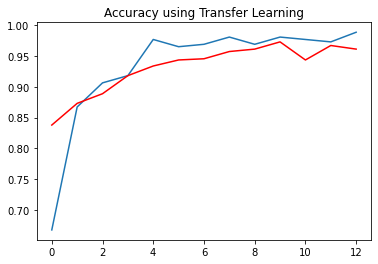

In [48]:
plt.plot(h['accuracy'])
plt.plot(h['val_accuracy'],c='red')
plt.title('Accuracy using Transfer Learning')
plt.show()

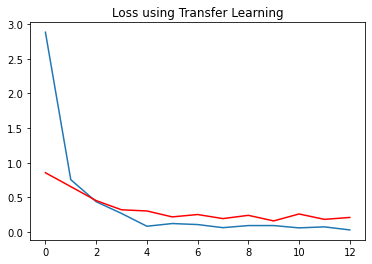

In [49]:
plt.plot(h['loss'])
plt.plot(h['val_loss'],c='red')
plt.title('Loss using Transfer Learning')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


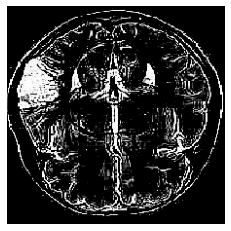

Brain Tumor Detected


In [69]:
from keras.preprocessing.image import load_img,img_to_array
path= "./Brain Tumor Data Set/Brain Tumor/Cancer (1311).jpg"

img=load_img(path,target_size=(224,224))
input_arr=img_to_array(img)
input_arr=preprocess_input(input_arr)
plt.imshow(input_arr)
plt.axis("off")
plt.show()
input_arr=np.expand_dims(input_arr,axis=0)

pred=np.argmax(model.predict(input_arr))

if(pred==0):
    print("Brain Tumor Detected")

else:
    print("No Brain Tumor")

In [73]:
def predict(path):
    img=load_img(path,target_size=(224,224))
    input_arr=img_to_array(img)
    input_arr=preprocess_input(input_arr)
    plt.imshow(input_arr)
    plt.axis("off")
    plt.show()
    input_arr=np.expand_dims(input_arr,axis=0)

    pred=np.argmax(model.predict(input_arr))

    if(pred==0):
        print("Brain Tumor Detected")

    else: 
        print("No Brain Tumor")
    

In [74]:
print(os.getcwd())

C:\Users\DELL\3D Objects\BrainTumorDetection


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


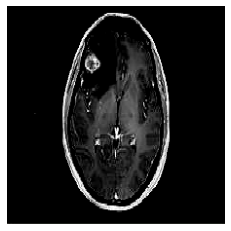

Brain Tumor Detected


In [75]:
predict('./sample.jpg')